# Phase noise simulations

## Import zone

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as ct
import os

from matplotlib.colors import LogNorm
from electrode import shaped

from src.systems.linear_traps import ThreeRFTrap
from src.io.loading import load_threeRF_geometry
from src.geometry.geometry_utils import check_all_ccw

from matplotlib import rcParams

# --- Style settings (as before) ---
rcParams['font.family'] = 'STIXGeneral'
rcParams['mathtext.fontset'] = 'stix'
rcParams['axes.unicode_minus'] = False
rcParams.update({
    "font.size": 14,
    "axes.labelsize": 15,
    "axes.titlesize": 15,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "axes.linewidth": 1.2,
    "lines.linewidth": 1.5,
    "grid.alpha": 0.6,
    "grid.linestyle": "--",
    "figure.facecolor": "white",
    "axes.facecolor": "white",
})

## Load trap geometry

In [6]:
geometry = load_threeRF_geometry("src/resources/ThreeRF_params.json")

# Trench width
trench_width = 5

# Set segmentation flags
flags = {
    "build_outer_RF": True,
    "build_central_RF": True,
}

flags_outer = {"build_central_RF": False}
flags_central = {"build_outer_RF": False}

# Build trap
trap = ThreeRFTrap(geometry, trench_width, flags)
system = trap.build()
system_central = trap.build(flags=flags_central)
system_outer = trap.build(flags=flags_outer)

check_all_ccw(system)
check_all_ccw(system_outer)
check_all_ccw(system_central)

All electrodes are CCW.
All electrodes are CCW.
All electrodes are CCW.


/home/kallo27/thesis/src/systems/linear_traps.py:240: UserWarning: Flag 'build_outer_RF' is False, but RF geometry is provided.
  warnings.warn("Flag 'build_outer_RF' is False, but RF geometry is provided.")
/home/kallo27/thesis/src/systems/linear_traps.py:236: UserWarning: Flag 'build_central_RF' is False, but RF geometry is provided.
  warnings.warn("Flag 'build_central_RF' is False, but RF geometry is provided.")


## Build system and compute pseudopotential

In this case we need to build the pseudopotential directly from the electric field (sum of two different electric fields), because we want to introduce a phase in the voltages, which must be added in the fields.

In [7]:
csi_values = np.linspace(-1., 1.5, 1001)
x0 = (0., 0., 350.)
x1 = (0., 0., 10.)
minimum_positions_0 = []
pot_values_0 = []
E_norm_sqr = []
secular_frequencies = []

L = 1e-6 # um length scale
M = 40 * ct.atomic_mass # ion mass (calcium)
Q = 1 * ct.elementary_charge # ion charge (single-ion)
Omega = 2 * np.pi * 19e6
V0 = 100

scale = Q / (2 * Omega * np.sqrt(M))

for csi in csi_values:
    A1 = csi
    A2 = 1
    
    voltages = {
        "central_RF": {"attr": "rf", "value": A1},
        "outer_RF": {"attr": "rf", "value": A2},
    }

    voltages_central = {"central_RF": {"attr": "rf", "value": 1}}
    voltages_outer = {"outer_RF": {"attr": "rf", "value": 1}}

    system = trap.build(voltages)
    system_central = trap.build(voltages_central, flags_central)
    system_outer = trap.build(voltages_outer, flags_outer)

    try:
        if csi > 0.75:
            x0[0] += 1
        x0 = system.minimum(x0=(x0[0], x0[1], x0[2]), axis=(0,2), coord=np.identity(3), method="Powell")
        minimum_positions_0.append(x0)
        
        E1 = system_central.electrical_potential(x=x0, typ="rf", derivative=1)
        E2 = system_outer.electrical_potential(x=x0, typ="rf", derivative=1)
        
        ERF1 = A1 * E1
        ERF2 = A2 * E2
        ERF = ERF1 + ERF2
        
        E_norm_sqr.append(np.einsum("ij,ij->i", ERF, ERF))
        pot_values_0.append(scale**2 * np.einsum("ij,ij->i", ERF, ERF) * (V0/L)**2)
        
        # Compute secular frequencies
        curve_z = system.modes(x0)
        omega_sec = np.sqrt(abs(curve_z[0]) / M * (scale * V0 / L**2)**2)
        secular_frequencies.append(omega_sec)
    except:
        print(csi, "minimum not found")

/home/kallo27/anaconda3/lib/python3.11/site-packages/electrode-1.5+dev-py3.11-linux-x86_64.egg/electrode/system.py:439: RuntimeWarning: Method Powell does not use gradient information (jac).
  res = optimize.minimize(fun=f, x0=x0, jac=g, hess=h,
/home/kallo27/anaconda3/lib/python3.11/site-packages/electrode-1.5+dev-py3.11-linux-x86_64.egg/electrode/system.py:439: RuntimeWarning: Method Powell does not use Hessian information (hess).
  res = optimize.minimize(fun=f, x0=x0, jac=g, hess=h,


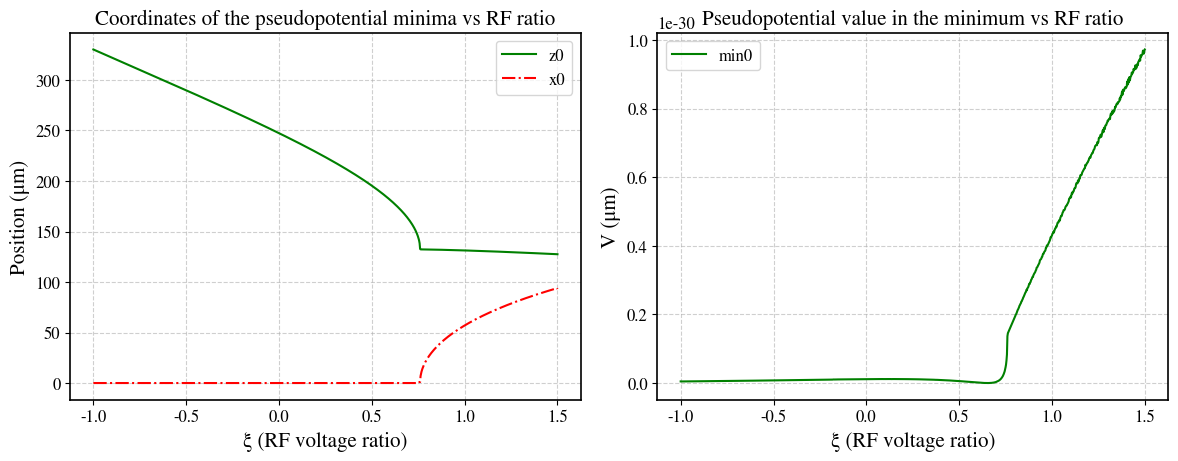

In [8]:
# Convert to arrays for slicing
min_pos_0 = np.array(minimum_positions_0)

# Create figure and axis
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# FIRST SUBPLOT - COORDINATES OF THE PSEUDOPOTENTIAL MINIMA
axs[0].plot(csi_values, min_pos_0[:, 2], label='z0', color='green', linestyle='-')
axs[0].plot(csi_values, min_pos_0[:, 0], label='x0', color='red', linestyle='-.')

axs[0].set_xlabel('ξ (RF voltage ratio)')
axs[0].set_ylabel('Position (μm)')
axs[0].set_title('Coordinates of the pseudopotential minima vs RF ratio')
axs[0].grid(True)
axs[0].legend()

# FIRST SUBPLOT - PSEUDOPOTENTIAL VALUE IN THE MINIMUM
axs[1].plot(csi_values, pot_values_0, label='min0', color='green', linestyle='-')
#axs[1].plot(csi_values[csi_values>0.16], pot_values_1, label='min1', color='red', linestyle='-.')

axs[1].set_xlabel('ξ (RF voltage ratio)')
axs[1].set_ylabel('V (μm)')
axs[1].set_title('Pseudopotential value in the minimum vs RF ratio')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

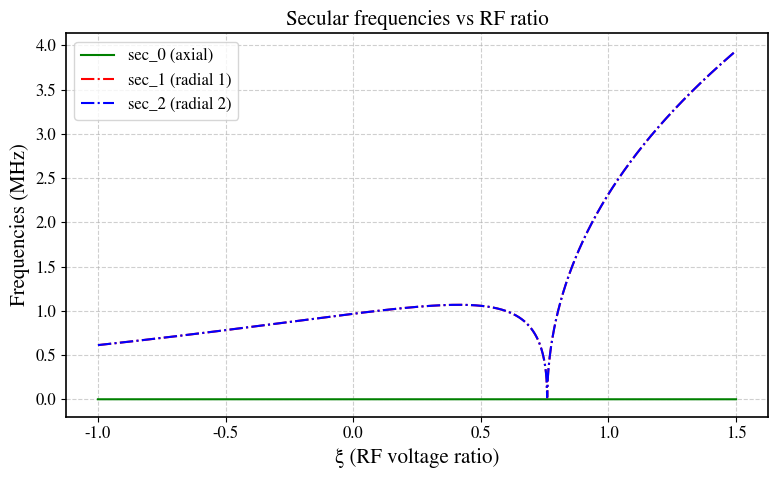

In [9]:
# Convert to arrays for slicing
sec_0 = np.array(secular_frequencies)[:,0]/(2*np.pi)/1e6
sec_1 = np.array(secular_frequencies)[:,1]/(2*np.pi)/1e6
sec_2 = np.array(secular_frequencies)[:,2]/(2*np.pi)/1e6

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot z and x components for both datasets
ax.plot(csi_values, sec_0, label='sec_0 (axial)', color='green', linestyle='-')
ax.plot(csi_values, sec_1, label='sec_1 (radial 1)', color='red', linestyle='-.')
ax.plot(csi_values, sec_2, label='sec_2 (radial 2)', color='blue', linestyle='-.')

# Add labels and grid
ax.set_xlabel('ξ (RF voltage ratio)')
ax.set_ylabel('Frequencies (MHz)')
ax.set_title('Secular frequencies vs RF ratio')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

## Plot nicely for thesis

In [27]:
from matplotlib.colors import LogNorm

def plot_phase_frames(trap, scale, V0, L, Q, indices, alpha_values=None,
                      x0_init=(0., 0., 200.), x1_init=(0., 0., 10.),
                      n=100, xmin=-400., xmax=400., zmin=10., zmax=400., y_cut=0):

    if alpha_values is None:
        alpha_values = np.linspace(-50, 50, 1001)

    frames_data = {}
    x0, x1 = list(x0_init), list(x1_init)

    # Compute all frames
    for i, alpha in enumerate(alpha_values):
        try:
            A1, A2 = 1, 1

            voltages = {
                "central_RF": {"attr": "rf", "value": A1 * V0 * scale},
                "outer_RF": {"attr": "rf", "value": A2 * V0 * scale},
            }

            voltages_central = {"central_RF": {"attr": "rf", "value": 1}}
            voltages_outer = {"outer_RF": {"attr": "rf", "value": 1}}
            
            system = trap.build(voltages)
            system_central = trap.build(voltages_central, flags_central)
            system_outer = trap.build(voltages_outer, flags_outer)

            xyz = np.mgrid[xmin:xmax:1j*n, y_cut:y_cut+0.1, zmin:zmax:1j*n]
            ERF1 = shaped(system_central.electrical_potential)(xyz, typ="rf", derivative=1)
            ERF2 = shaped(system_outer.electrical_potential)(xyz, typ="rf", derivative=1)
            ERF1, ERF2 = (_.reshape(n, n, 3) for _ in (ERF1, ERF2))
    
            ERF = np.array(A1 * ERF1 * np.exp(1j * np.deg2rad(alpha))) + np.array(A2 * ERF2)
            ERF_norm_sq = np.real(np.einsum("ijk,ijk->ij", np.conj(ERF), ERF))
            phi = scale**2 * ERF_norm_sq * (V0/L)**2

            x0 = system.minimum(x0=(x0[0], x0[1], x0[2]), axis=(0,1,2), coord=np.identity(3), method="Powell")
            
            if alpha < -20 or alpha > 20:
                x0 = (0, 0, 225)
            
            delta_phi = (phi - np.min(phi))/Q
            delta_phi[delta_phi < 0] = 1e-20
            

            if i in indices:
                frames_data[i] = (alpha, delta_phi, tuple(x0), tuple(x1))

        except Exception as e:
            print(f"α = {alpha:.3f}: skipped ({e})")

    # Plot selected frames
    fig, axes = plt.subplots(1, len(indices), figsize=(4*len(indices), 4), sharey=True)
    if len(indices) == 1:
        axes = [axes]

    ims = []

    for ax, idx in zip(axes, indices):
        if idx not in frames_data:
            ax.text(0.5, 0.5, f"Frame {idx} missing", ha='center', va='center')
            ax.axis('off')
            continue

        alpha, delta_phi, x0, x1 = frames_data[idx]

        im = ax.imshow(delta_phi.T, origin='lower', extent=(xmin, xmax, zmin, zmax),
                       norm=LogNorm(vmin=1e-2, vmax=1), cmap='viridis', aspect='auto')
        im.set_interpolation('bilinear')
        ims.append(im)

        ax.scatter(x0[0], x0[2], color='cyan', marker='o', s=10)
        ax.scatter(-x0[0], x0[2], color='cyan', marker='o', s=10)

        ax.set_xlabel(r'$x \ \mathrm{(\mu m)}$', fontsize=15)
        ax.tick_params(axis='both', labelsize=12)
        ax.set_xticklabels([])

    axes[0].set_ylabel(r'$z \ \mathrm{(\mu m)}$', fontsize=15)

    # Single colorbar on the right
    cbar_ax = fig.add_axes([0.91, 0.11, 0.01, 0.77])
    cbar = fig.colorbar(ims[0], cax=cbar_ax, label=r"$\mathrm{log}(\Phi_\mathrm{RF}) \ (\mathrm{a.u.})$")
    cbar.ax.yaxis.label.set_size(15)
    cbar.set_ticks([])

    fig.subplots_adjust(wspace=0.05)
    return fig


/home/kallo27/thesis/src/systems/linear_traps.py:240: UserWarning: Flag 'build_outer_RF' is False, but RF geometry is provided.
  warnings.warn("Flag 'build_outer_RF' is False, but RF geometry is provided.")
/home/kallo27/thesis/src/systems/linear_traps.py:236: UserWarning: Flag 'build_central_RF' is False, but RF geometry is provided.
  warnings.warn("Flag 'build_central_RF' is False, but RF geometry is provided.")
/home/kallo27/anaconda3/lib/python3.11/site-packages/electrode-1.5+dev-py3.11-linux-x86_64.egg/electrode/system.py:439: RuntimeWarning: Method Powell does not use gradient information (jac).
  res = optimize.minimize(fun=f, x0=x0, jac=g, hess=h,
/home/kallo27/anaconda3/lib/python3.11/site-packages/electrode-1.5+dev-py3.11-linux-x86_64.egg/electrode/system.py:439: RuntimeWarning: Method Powell does not use Hessian information (hess).
  res = optimize.minimize(fun=f, x0=x0, jac=g, hess=h,


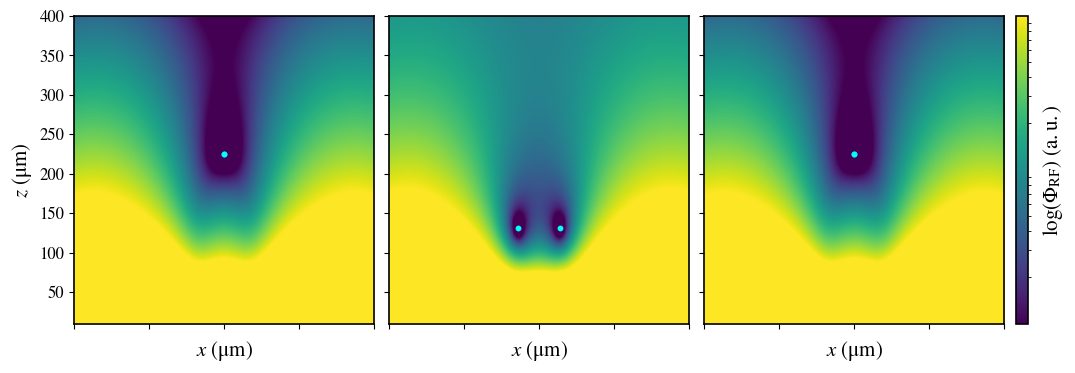

In [29]:
# Grid parameters
n = 100
xmin, xmax = -400., 400.
zmin, zmax = 10., 400.
y_cut = 0.  # assume y = 0 slice
x0 = (0., 0., 200.)
x1 = (0., 0., 10.)
alpha_values = np.linspace(-50, 50, 1001)

fig = plot_phase_frames(trap, scale, V0, L, Q, [100, 500, 900], alpha_values)
fig.savefig("/home/kallo27/thesis/thesis_images/ps_phase_mismatch.pdf", bbox_inches="tight")

## MC simulations

In [12]:
def MC_noisy_potential(A1, A2, E1, E2, mean_csi, sigma_csi, num_samples, mode="mixed"):
    E_sqr = []
    pot = []
    
    for _ in range(num_samples):
        # Noise phases default (no noise)
        alpha_rf1 = 0
        alpha_rf2 = 0
        
        if mode == 'outer':
            alpha_rf2 = np.deg2rad(np.random.normal(mean_csi, sigma_csi))
        elif mode == 'inner':
            alpha_rf1 = np.deg2rad(np.random.normal(mean_csi, sigma_csi))
        elif mode == 'mixed':
            alpha_rf1 = np.deg2rad(np.random.normal(mean_csi, sigma_csi))
            alpha_rf2 = np.deg2rad(np.random.normal(mean_csi, sigma_csi))
        else:
            raise ValueError(f"Unknown mode: {mode}")

        phase1 = np.exp(1j * alpha_rf1)
        phase2 = np.exp(1j * alpha_rf2)
    
        ERF1 = A1 * E1 * phase1
        ERF2 = A2 * E2 * phase2
        ERF = ERF1 + ERF2
    
        E_sqr.append(np.real(np.einsum("ij,ij->i", np.conj(ERF), ERF)))
        pot.append(scale**2 * np.real(np.einsum("ij,ij->i", np.conj(ERF), ERF)) * (V0/L)**2)
    
    return np.mean(E_sqr), np.mean(pot)

In [19]:
csi_values = np.linspace(-1., 1.5, 1001)
csi_values[csi_values == 0] = 1e-12
x0 = (0., 0., 350.)
minimum_positions_0 = []
pot_values_0 = []
pot_values_outer = []
pot_values_inner = []
pot_values_mixed = []
E_values_outer = []
E_values_inner = []
E_values_mixed = []

sigma_csi = 0.01
mean_csi = 0
num_samples = 1000

for csi in csi_values:
    A1 = csi
    A2 = 1
    
    voltages = {
        "central_RF": {"attr": "rf", "value": A1},
        "outer_RF": {"attr": "rf", "value": A2},
    }

    voltages_central = {"central_RF": {"attr": "rf", "value": 1}}
    voltages_outer = {"outer_RF": {"attr": "rf", "value": 1}}

    system = trap.build(voltages)
    system_central = trap.build(voltages_central, flags_central)
    system_outer = trap.build(voltages_outer, flags_outer)

    try:
        if csi > 0.75:
            x0[0] += 1
        x0 = system.minimum(x0=(x0[0], x0[1], x0[2]), axis=(0,2), coord=np.identity(3), method="Powell")
        minimum_positions_0.append(x0)

        E1 = system_central.electrical_potential(x=x0, typ="rf", derivative=1, expand=True)
        E2 = system_outer.electrical_potential(x=x0, typ="rf", derivative=1, expand=True)
    
    except:
        print(csi, "minimum not found")
        
    mean_E_outer, mean_pot_outer = MC_noisy_potential(A1, A2, E1, E2, mean_csi, sigma_csi, num_samples, mode="outer")
    mean_E_inner, mean_pot_inner = MC_noisy_potential(A1, A2, E1, E2, mean_csi, sigma_csi, num_samples, mode="inner")
    mean_E_mixed, mean_pot_mixed = MC_noisy_potential(A1, A2, E1, E2, mean_csi, sigma_csi, num_samples, mode="mixed")
    
    pot_values_outer.append(mean_pot_outer)
    pot_values_inner.append(mean_pot_inner)
    pot_values_mixed.append(mean_pot_mixed)
    E_values_outer.append(mean_E_outer)
    E_values_inner.append(mean_E_inner)
    E_values_mixed.append(mean_E_mixed)

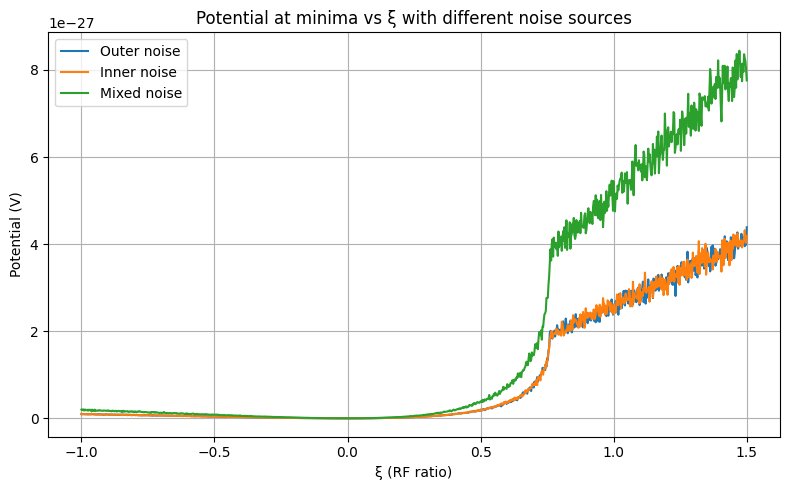

In [20]:
plt.figure(figsize=(8, 5))

# Plot all potentials
plt.plot(csi_values, pot_values_outer, label='Outer noise', color='tab:blue')
plt.plot(csi_values, pot_values_inner, label='Inner noise', color='tab:orange')
plt.plot(csi_values, pot_values_mixed, label='Mixed noise', color='tab:green')

# Axis labels and title
plt.xlabel('ξ (RF ratio)')
plt.ylabel('Potential (V)')
plt.title('Potential at minima vs ξ with different noise sources')

# Grid and legend
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()